# memory network for question answering

In [66]:
from keras.layers import Input
from keras.layers.core import Activation,Dropout,Permute,Dense
from keras.layers.embeddings import Embedding
from keras.layers.merge import add,concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os

In [26]:
train_file = "qa1_single-supporting-fact_train.txt"
test_file = "qa1_single-supporting-fact_test.txt"

In [29]:
def get_data(infile):
    stories, questions, answers = [], [], []
    story_text = []
    fin = open(infile, "rb")
    for line in fin:
        line = line.decode("utf-8").strip()
        lno, text = line.split(" ", 1)
        if "\t" in text:
            question, answer, _ = text.split("\t")
            stories.append(story_text)
            questions.append(question)
            answers.append(answer)
            story_text = []
             
        else:
            story_text.append(text)
    fin.close()
    return stories, questions, answers
data_train = get_data(train_file)
data_test = get_data(test_file)

In [35]:
def build_vocab(train_data, test_data):
    counter = collections.Counter()
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            for sent in story:
                for word in nltk.word_tokenize(sent):
                    counter[word.lower()] += 1
        for question in questions:
            for word in nltk.word_tokenize(question):
                counter[word.lower()] += 1
        for answer in answers:
            for word in nltk.word_tokenize(answer):
                counter[word.lower()] += 1
    # no OOV here because there are not too many words in dataset
    word2idx = {w:(i+1) for i, (w, _) in enumerate(counter.most_common())}
    word2idx["PAD"] = 0
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word

In [39]:
word2idx, idx2word = build_vocab(data_train,data_test)

In [41]:
def get_maxlens(train_data, test_data):
    story_maxlen, question_maxlen = 0, 0
    for stories, questions, _ in [train_data, test_data]:
        for story in stories:
            story_len = 0
            for sent in story:
                swords = nltk.word_tokenize(sent)
                story_len += len(swords)
            if story_len > story_maxlen:
                story_maxlen = story_len
        for question in questions:
            question_len = len(nltk.word_tokenize(question))
            if question_len > question_maxlen:
                question_maxlen = question_len
    return story_maxlen, question_maxlen

In [42]:
story_maxlen, question_maxlen = get_maxlens(data_train, data_test)

In [44]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2idx[w.lower()] for w in nltk.word_tokenize(s)] 
                                   for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        xq = [word2idx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer.lower()])
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           np_utils.to_categorical(Y, num_classes=len(word2idx))

In [49]:
Xstrain, Xqtrain, Ytrain = vectorize(data_train, word2idx, story_maxlen, question_maxlen)
Xstest, Xqtest, Ytest    = vectorize(data_test, word2idx, story_maxlen, question_maxlen)

In [67]:
vocab_size = len(word2idx)
EMBEDDING_SIZE = 64
LATENT_SIZE = 32
BATCH_SIZE = 64
NUM_EPOCHS = 10

# inputs
story_input = Input(shape=(story_maxlen,))
question_input = Input(shape=(question_maxlen,))

# story encoder memory
story_encoder = Embedding(input_dim=vocab_size,
                         output_dim=EMBEDDING_SIZE,
                         input_length=story_maxlen)(story_input)
story_encoder = Dropout(0.3)(story_encoder)

# question encoder
question_encoder = Embedding(input_dim=vocab_size,
                            output_dim=EMBEDDING_SIZE,
                            input_length=question_maxlen)(question_input)
question_encoder = Dropout(0.3)(question_encoder)

# match between story and question
match = dot([story_encoder, question_encoder], axes=[2, 2])

# encode story into vector space of question
story_encoder_c = Embedding(input_dim=vocab_size,
                           output_dim=question_maxlen,
                           input_length=story_maxlen)(story_input)
story_encoder_c = Dropout(0.3)(story_encoder_c)

# combine match and story vectors
response = add([match, story_encoder_c])
response = Permute((2, 1))(response)

# combine response and question vectors
answer = concatenate([response, question_encoder], axis=-1)
answer = LSTM(LATENT_SIZE)(answer)
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)
output = Activation("softmax")(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
              metrics=["accuracy"])

# train model
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=([Xstest, Xqtest], [Ytest]))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 201us/step - loss: 2.0098 - acc: 0.1887 - val_loss: 1.6930 - val_acc: 0.2730
Epoch 2/10
10000/10000 [==============================] - 1s 104us/step - loss: 1.6992 - acc: 0.2683 - val_loss: 1.6609 - val_acc: 0.2910
Epoch 3/10
10000/10000 [==============================] - 1s 98us/step - loss: 1.6400 - acc: 0.3133 - val_loss: 1.5963 - val_acc: 0.3750
Epoch 4/10
10000/10000 [==============================] - 1s 96us/step - loss: 1.5777 - acc: 0.3850 - val_loss: 1.5370 - val_acc: 0.4890
Epoch 5/10
10000/10000 [==============================] - 1s 97us/step - loss: 1.5074 - acc: 0.4547 - val_loss: 1.4744 - val_acc: 0.5000
Epoch 6/10
10000/10000 [==============================] - 1s 95us/step - loss: 1.4580 - acc: 0.4918 - val_loss: 1.4273 - val_acc: 0.5080
Epoch 7/10
10000/10000 [==============================] - 1s 96us/step - loss: 1.4134 - acc: 0.5055 - val_loss: 1.3843 - val_ac

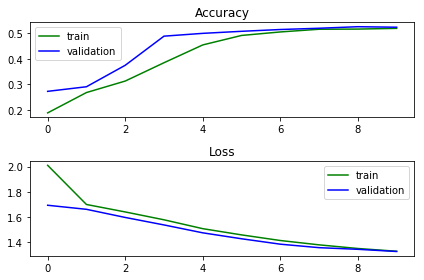

In [68]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [69]:
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

NUM_DISPLAY = 10

for i in range(NUM_DISPLAY):
    story = " ".join([idx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print(story, question, label, prediction)


(u'john travelled to the hallway . mary journeyed to the bathroom .', u'where is john ?', u'hallway', u'bathroom')
(u'daniel went back to the bathroom . john moved to the bedroom .', u'where is mary ?', u'bathroom', u'bedroom')
(u'john went to the hallway . sandra journeyed to the kitchen .', u'where is sandra ?', u'kitchen', u'kitchen')
(u'sandra travelled to the hallway . john went to the garden .', u'where is sandra ?', u'hallway', u'garden')
(u'sandra went back to the bathroom . sandra moved to the kitchen .', u'where is sandra ?', u'kitchen', u'kitchen')
(u'sandra travelled to the kitchen . sandra travelled to the hallway .', u'where is sandra ?', u'hallway', u'hallway')
(u'mary went to the bathroom . sandra moved to the garden .', u'where is sandra ?', u'garden', u'garden')
(u'sandra travelled to the office . daniel journeyed to the hallway .', u'where is daniel ?', u'hallway', u'hallway')
(u'daniel journeyed to the office . john moved to the hallway .', u'where is sandra ?', u'o